In [21]:
%load_ext autoreload
%autoreload 2

# Notebook for catboost model development and testing

scores, frequency 15min: 
training on observed data only 
- 173 med objective="MultiRSME", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 171 med objective="MAE", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 180 med vanlig catboost, trent på time series data. 

training on both observed and estimated 


TRAINING ON HOURLY DATA 

159 - using normal catboost


168 - using catboost with objective="MAE", learning_rate=0.10931167365445349 colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"



## Getting data


## Training on combined observed and estimated data

In [28]:
%store -r dm 

from sklearn.model_selection import train_test_split

dm = dm

X_A_train = dm.data_A.iloc[:, 3:-1]
y_A_train = dm.data_A.iloc[:,0]
X_B_train = dm.data_B.iloc[:, 3:-1]
y_B_train = dm.data_B.iloc[:,0]
X_C_train = dm.data_C.iloc[:, 3:-1]
y_C_train = dm.data_C.iloc[:,0]


X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A_train, y_A_train, shuffle=False, train_size=0.9)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B_train, y_B_train, shuffle=False, train_size=0.9)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C_train, y_C_train, shuffle=False, train_size=0.9)

X_A_submission = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_B_submission = dm.X_test_estimated_b[dm.X_test_estimated_b.columns.intersection(X_B_train.columns)]
X_C_submission = dm.X_test_estimated_c[dm.X_test_estimated_c.columns.intersection(X_C_train.columns)]

print(X_train_A.shape, y_train_A.shape, X_test_A.shape, y_test_A.shape)
print(X_train_B.shape, y_train_B.shape, X_test_B.shape, y_test_B.shape)
print(X_train_C.shape, y_train_C.shape, X_test_C.shape, y_test_C.shape)

X_A_train



(122620, 44) (122620,) (13625, 44) (13625,)
(121054, 44) (121054,) (13451, 44) (13451,)
(120960, 44) (120960,) (13441, 44) (13441,)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,month,hours
0,7.7,1.230,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,...,0.0,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,6,22
1,7.7,1.229,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,...,0.0,286.100006,100.000000,40123.898438,3.6,-3.6,-0.6,-0.0,6,22
2,7.7,1.228,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,...,0.0,286.299988,100.000000,40628.300781,3.6,-3.6,-0.4,-0.0,6,22
3,7.7,1.226,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,...,0.0,286.600006,100.000000,41153.601562,3.5,-3.5,-0.2,-0.0,6,22
4,7.7,1.225,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,...,0.0,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136240,4.5,1.281,0.0,0.0,0.0,272.299988,0.0,0.0,0.0,0.0,...,0.1,274.200012,99.900002,11629.299805,3.9,2.9,2.5,-0.0,4,22
136241,4.5,1.281,0.0,0.0,0.0,272.200012,0.0,0.0,0.0,0.0,...,0.1,274.200012,100.000000,9923.200195,3.7,2.8,2.4,-0.0,4,23
136242,4.5,1.281,0.0,0.0,0.0,272.299988,0.0,0.0,0.0,0.0,...,0.1,274.200012,99.900002,11230.799805,3.7,2.7,2.5,-0.0,4,23
136243,4.5,1.281,0.0,0.0,0.0,272.299988,0.0,0.0,0.0,0.0,...,0.1,274.200012,99.599998,12526.099609,3.8,2.7,2.6,-0.0,4,23


## Using timeseries split to split our data 

In [89]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=15,
    max_train_size=7000,
    test_size=1000,
)

all_splits_A = list(ts_cv.split(X_train_A, y_train_A))
all_splits_B = list(ts_cv.split(X_train_B, y_train_B))
all_splits_C = list(ts_cv.split(X_train_C, y_train_C))



In [10]:
from catboost import CatBoostRegressor

catModel_A = CatBoostRegressor()
catModel_B = CatBoostRegressor()
catModel_C = CatBoostRegressor()

## training on the time series split 

In [91]:

from sklearn.metrics import mean_absolute_error
import pandas as pd

for train, test in (all_splits_A): 

    catModel_A.fit(X_train_A.iloc[train], y_train_A.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_A.iloc[test], y_train_A.iloc[test]))

    preds_A = pd.DataFrame(catModel_A.predict(X_test_A))
    actual = y_test_A

    # preds_A = dm.scaling(preds_A, "A")
    # actual = dm.scaling(actual, "A") 

    print("CURRENT SCORING A ----->   ", mean_absolute_error(preds_A, actual))

for train, test in (all_splits_B): 

    catModel_B.fit(X_train_B.iloc[train], y_train_B.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_B.iloc[test], y_train_B.iloc[test]))

    preds_B = pd.DataFrame(catModel_B.predict(X_test_B))
    actual = y_test_B

    # preds_B = dm.scaling(preds_B, "B")
    # actual = dm.scaling(actual, "B") 

    print("CURRENT SCORING B ----->   ", mean_absolute_error(preds_B, actual))

for train, test in (all_splits_C): 

    catModel_C.fit(X_train_C.iloc[train], y_train_C.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_C.iloc[test], y_train_C.iloc[test]))

    preds_C = pd.DataFrame(catModel_C.predict(X_test_C))
    actual = y_test_C

    # preds_C = dm.scaling(preds_C, "C")
    # actual = dm.scaling(actual, "C") 

    print("CURRENT SCORING C ----->   ", mean_absolute_error(preds_C, actual))



CURRENT SCORING A ----->    140.55315803966158
CURRENT SCORING A ----->    151.35092125059577


KeyboardInterrupt: 

## training on the normally split data 

In [29]:

catModel_A.fit(X_train_A, y_train_A, silent=True)
catModel_B.fit(X_train_B, y_train_B, silent=True)
catModel_C.fit(X_train_C, y_train_C, silent=True)


In [30]:
import pandas as pd 
from sklearn.metrics import mean_absolute_error
preds_A = pd.DataFrame(catModel_A.predict(X_test_A))
actual = y_test_A

# preds_A = dm.scaling(preds_A, "A")
# actual = dm.scaling(actual, "A") 

print("CURRENT SCORING A ----->   ", mean_absolute_error(actual, preds_A))

preds_B = pd.DataFrame(catModel_B.predict(X_test_B))
actual = y_test_B

# preds_B = dm.scaling(preds_B, "B")
# actual = dm.scaling(actual, "B") 

print("CURRENT SCORING B ----->   ", mean_absolute_error(actual, preds_B))

preds_C = pd.DataFrame(catModel_C.predict(X_test_C))
actual = y_test_C

# preds_C = dm.scaling(preds_C, "C")
# actual = dm.scaling(actual, "C") 

print("CURRENT SCORING C ----->   ", mean_absolute_error(actual, preds_C))



CURRENT SCORING A ----->    77.80933159850315
CURRENT SCORING B ----->    14.54672662861283
CURRENT SCORING C ----->    7.9741138753886345


In [31]:
## Specify the model to be used
pred_A = catModel_A.predict(X_A_submission)
pred_B = catModel_B.predict(X_B_submission)
pred_C = catModel_C.predict(X_C_submission)

## Uncomment if normalizing data
# pred_A = dm.scaling(pred_A, "A")
# pred_B = dm.scaling(pred_B, "B")
# pred_C = dm.scaling(pred_C, "C")

test = pd.read_csv('test.csv')

df_A = pd.DataFrame()

df_A["prediction"] = pred_A
df_A["location"] = "A"

df_B = pd.DataFrame()

df_B["prediction"] = pred_B
df_B["location"] = "B"

df_C = pd.DataFrame()

df_C["prediction"] = pred_C
df_C["location"] = "C"

df_mid = pd.concat([df_A, df_B], ignore_index=True)

df = pd.concat([df_mid, df_C], join="inner", ignore_index=True)

df = df.drop("location", axis=1)


# df["id"] = test["id"]

# df = df[["id", "prediction"]]

df[df<0] = 0

# NAME THE FILE 
df.to_csv("sub61.csv")

df

,prediction
0,5.257110
1,6.053675
2,6.971668
3,90.277474
4,321.826463
...,...
2155,49.137815
2156,20.789074
2157,9.283888
2158,1.415344


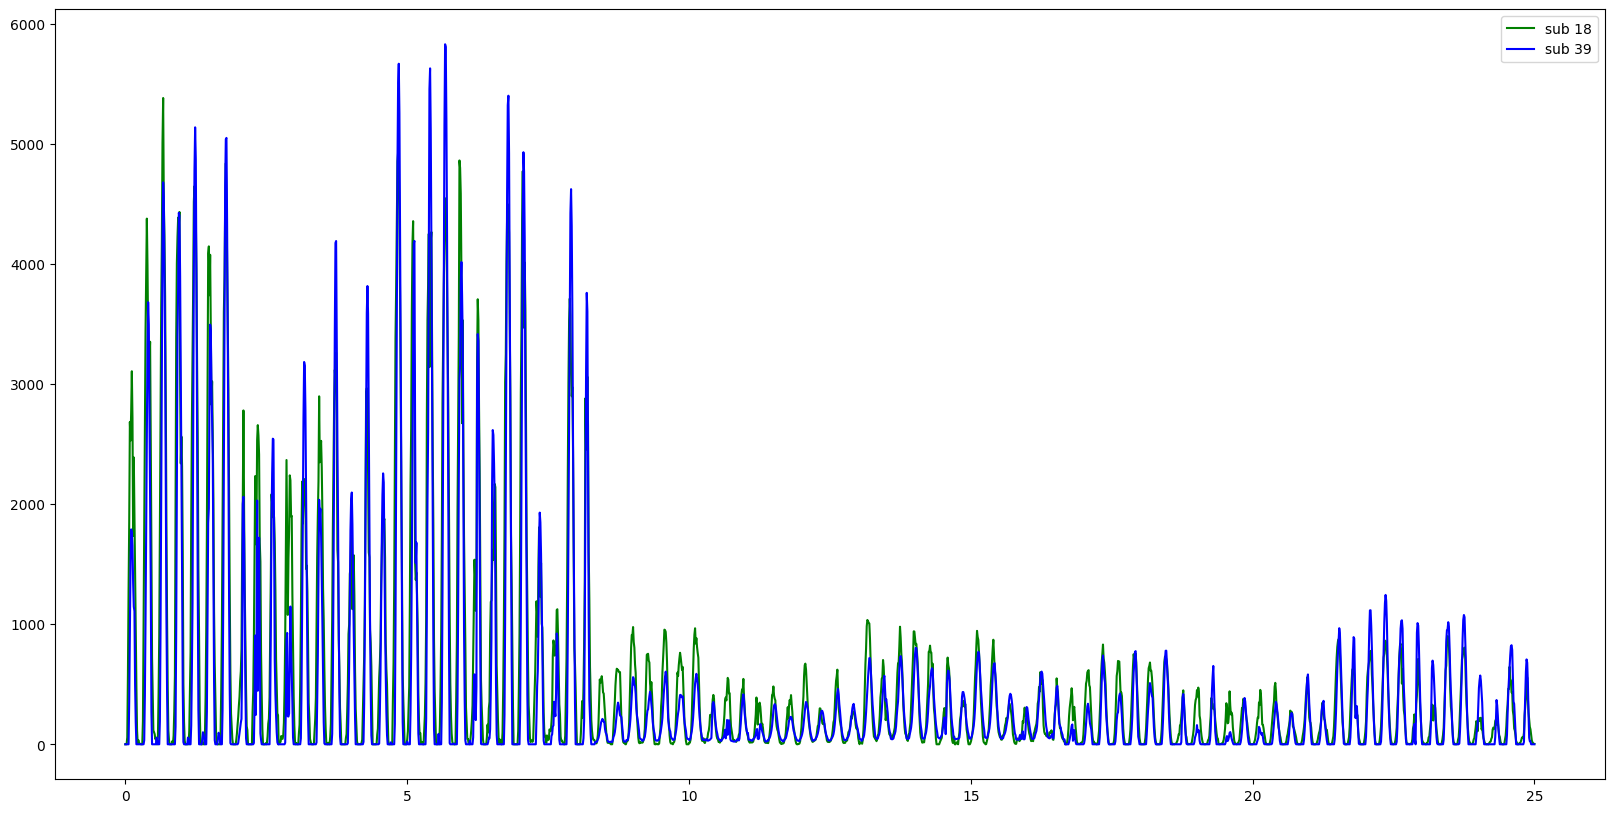

110.53349677672395


In [15]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
import pandas as pd

s18 = pd.read_csv("sub18.csv")
s39 = pd.read_csv("sub39.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub39.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 39") 

plt.legend() 
plt.show() 

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(s18, s39))



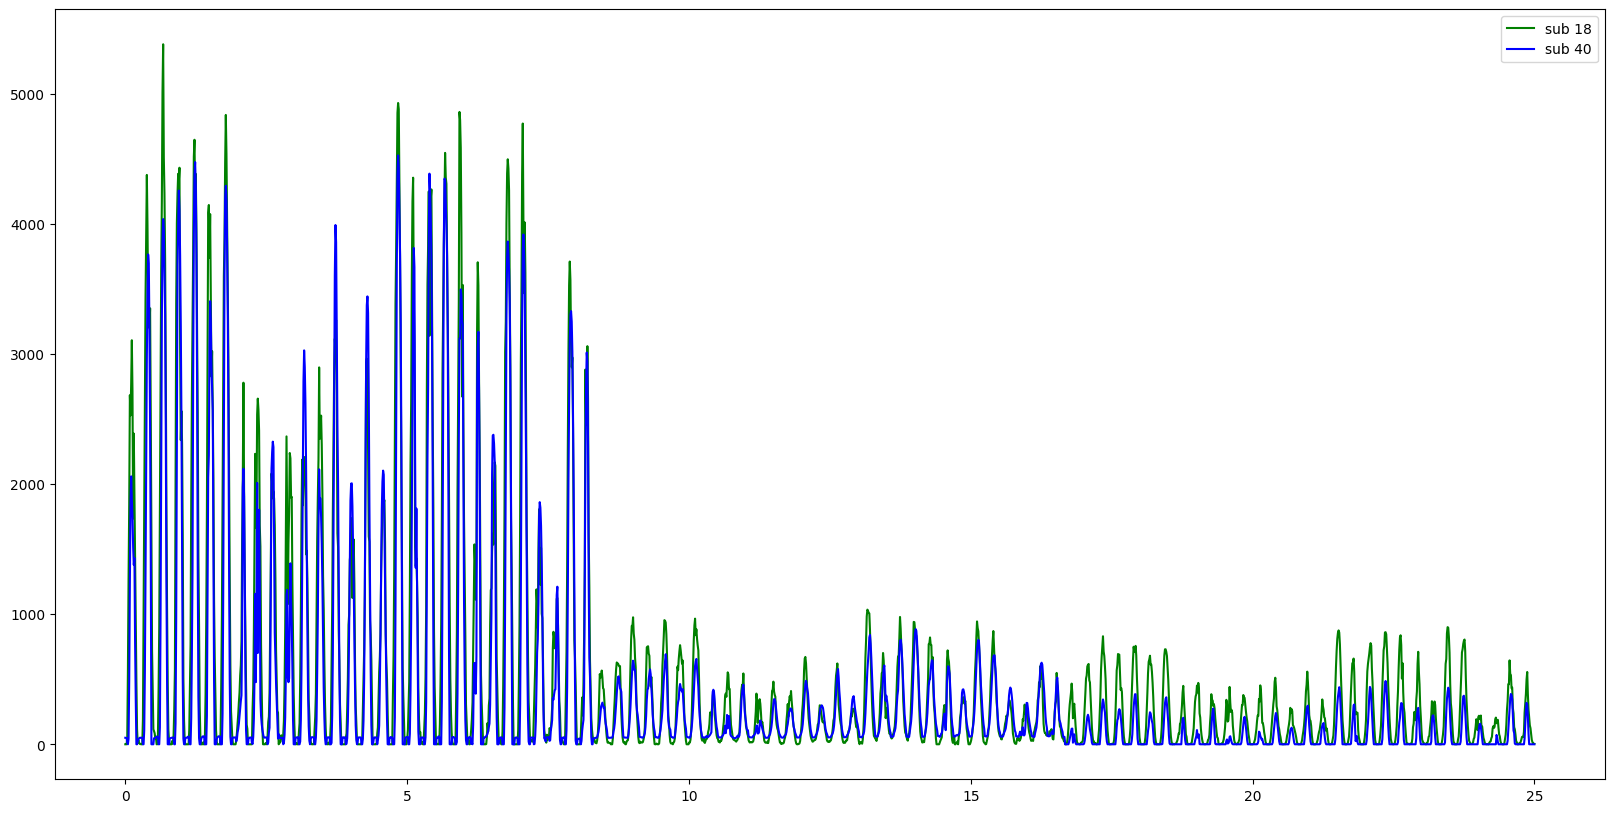

106.30018849256551


In [8]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 

s40 = pd.read_csv("sub40.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub40.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 40") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s40))

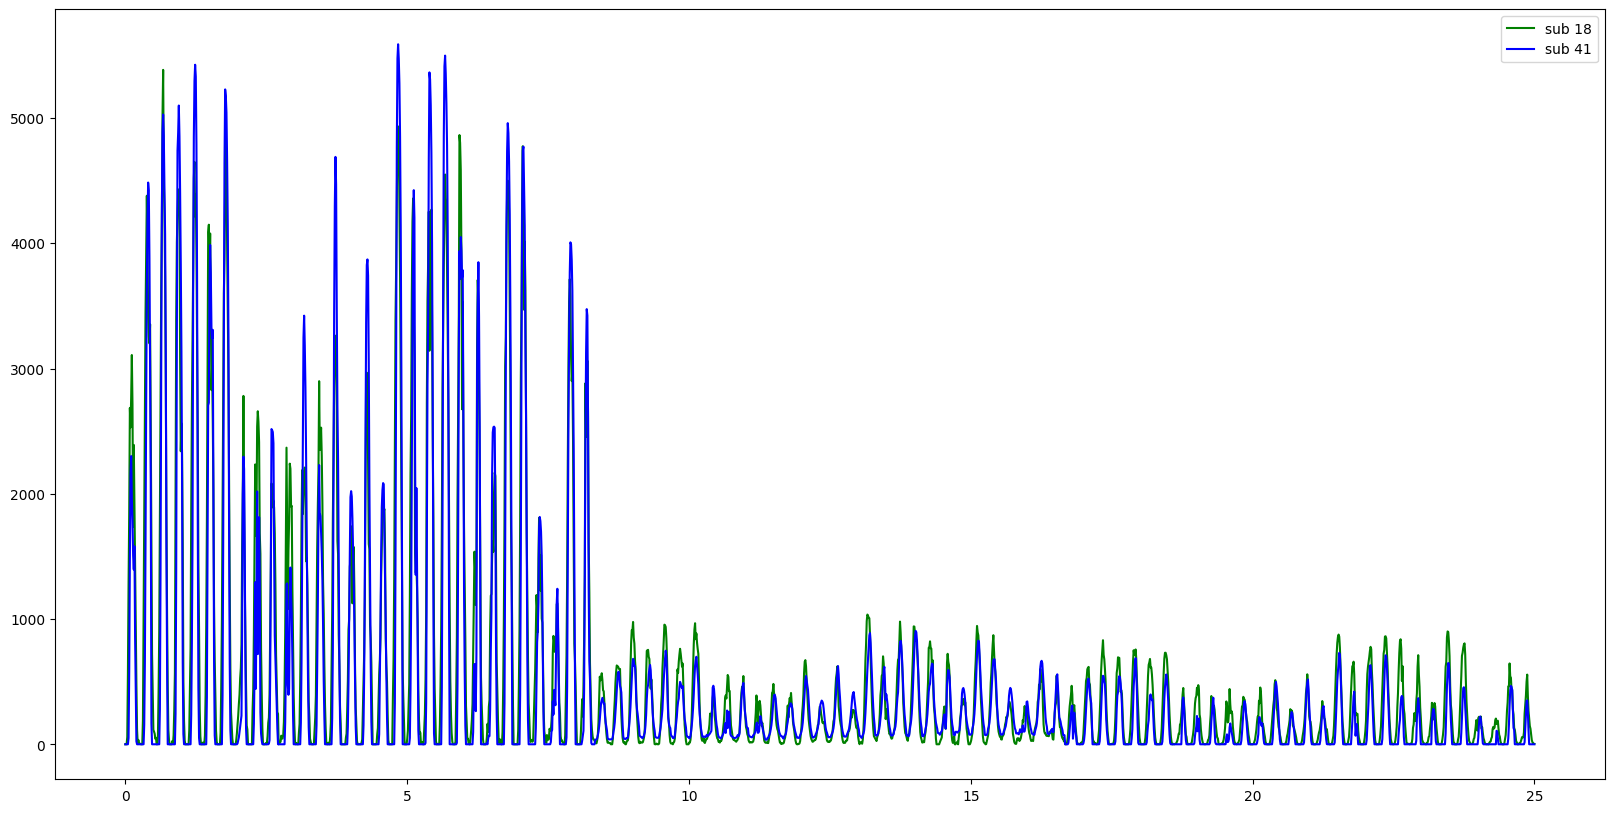

98.48684453609533


In [9]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 

s41 = pd.read_csv("sub41.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub41.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 41") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s41))

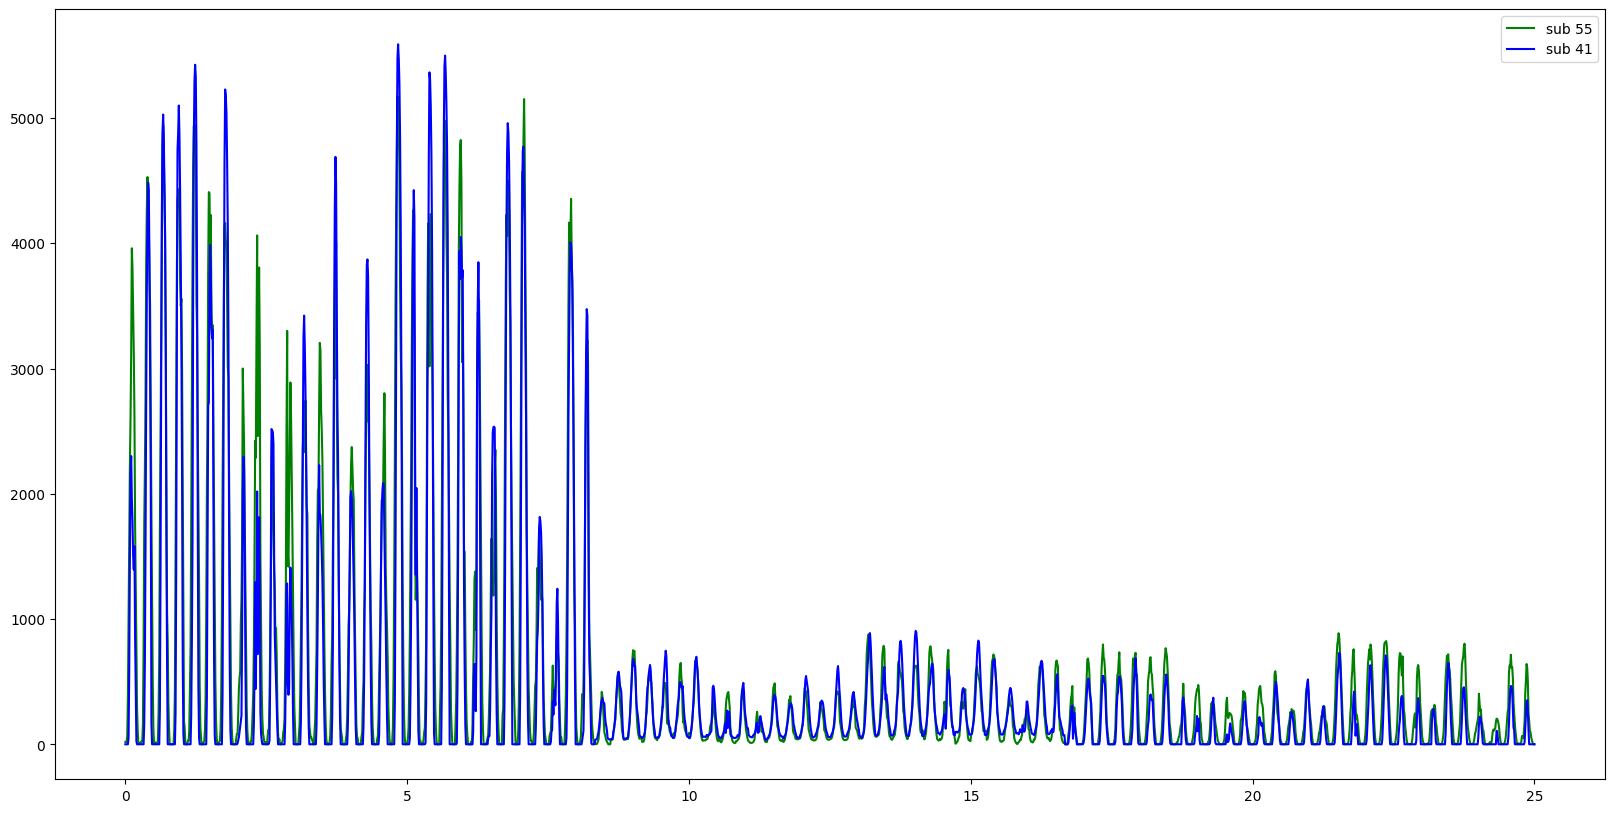

98.48684453609533


In [113]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
s55 = pd.read_csv("sub55.csv")
s52 = pd.read_csv("sub41.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub55.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 55") 

y2 = [] 
  
with open('sub41.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 41") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s52))

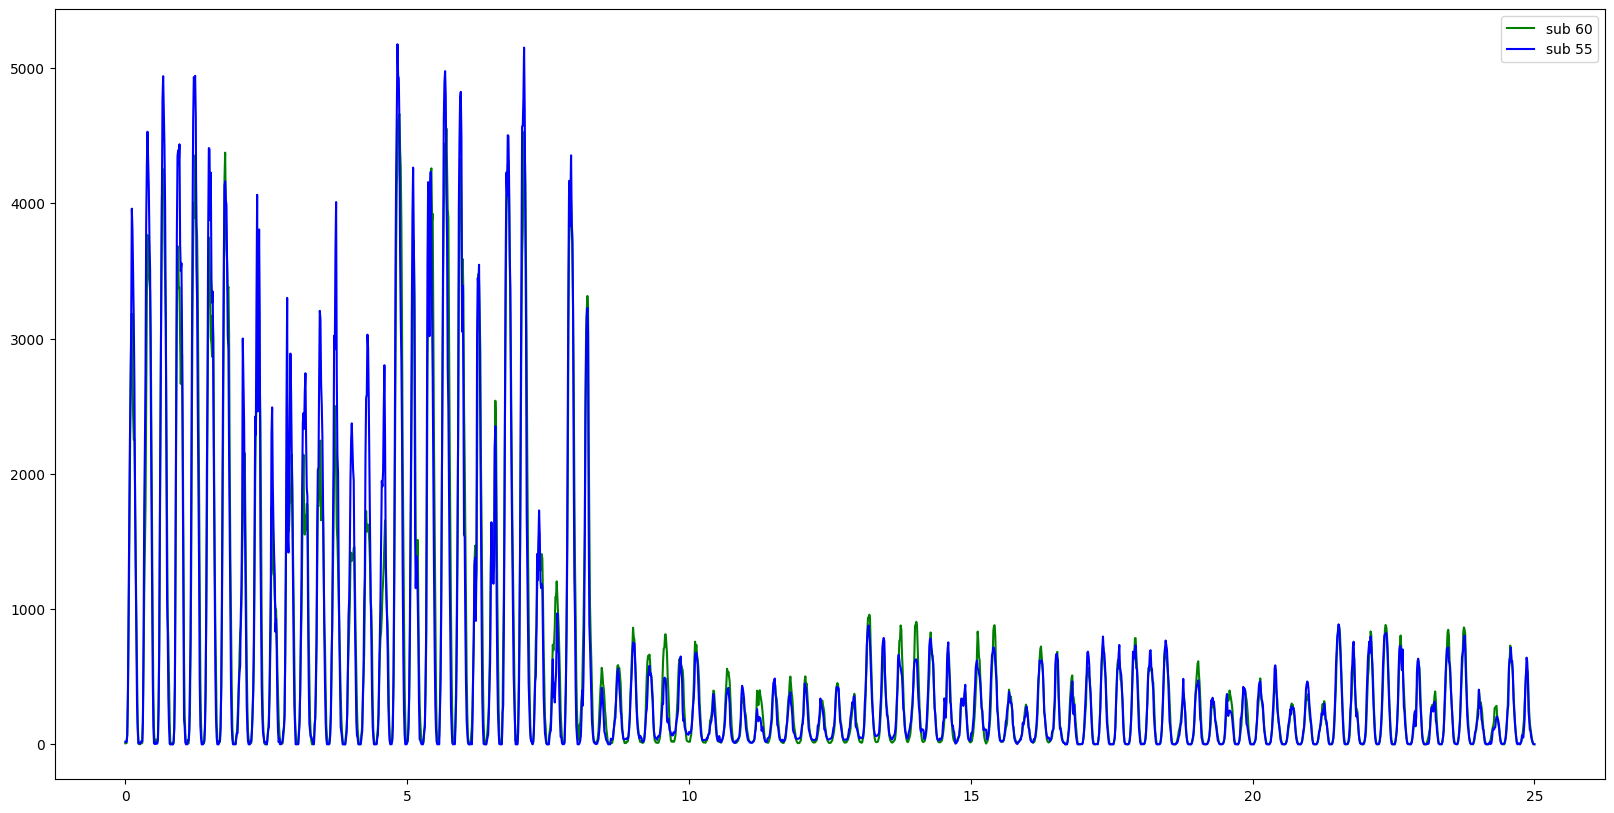

62.57833574696834


In [16]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
s60 = pd.read_csv("sub60.csv")
s55 = pd.read_csv("sub55.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub60.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 60") 

y2 = [] 
  
with open('sub55.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 55") 

plt.legend() 
plt.show()

print(mean_absolute_error(s55, s60))

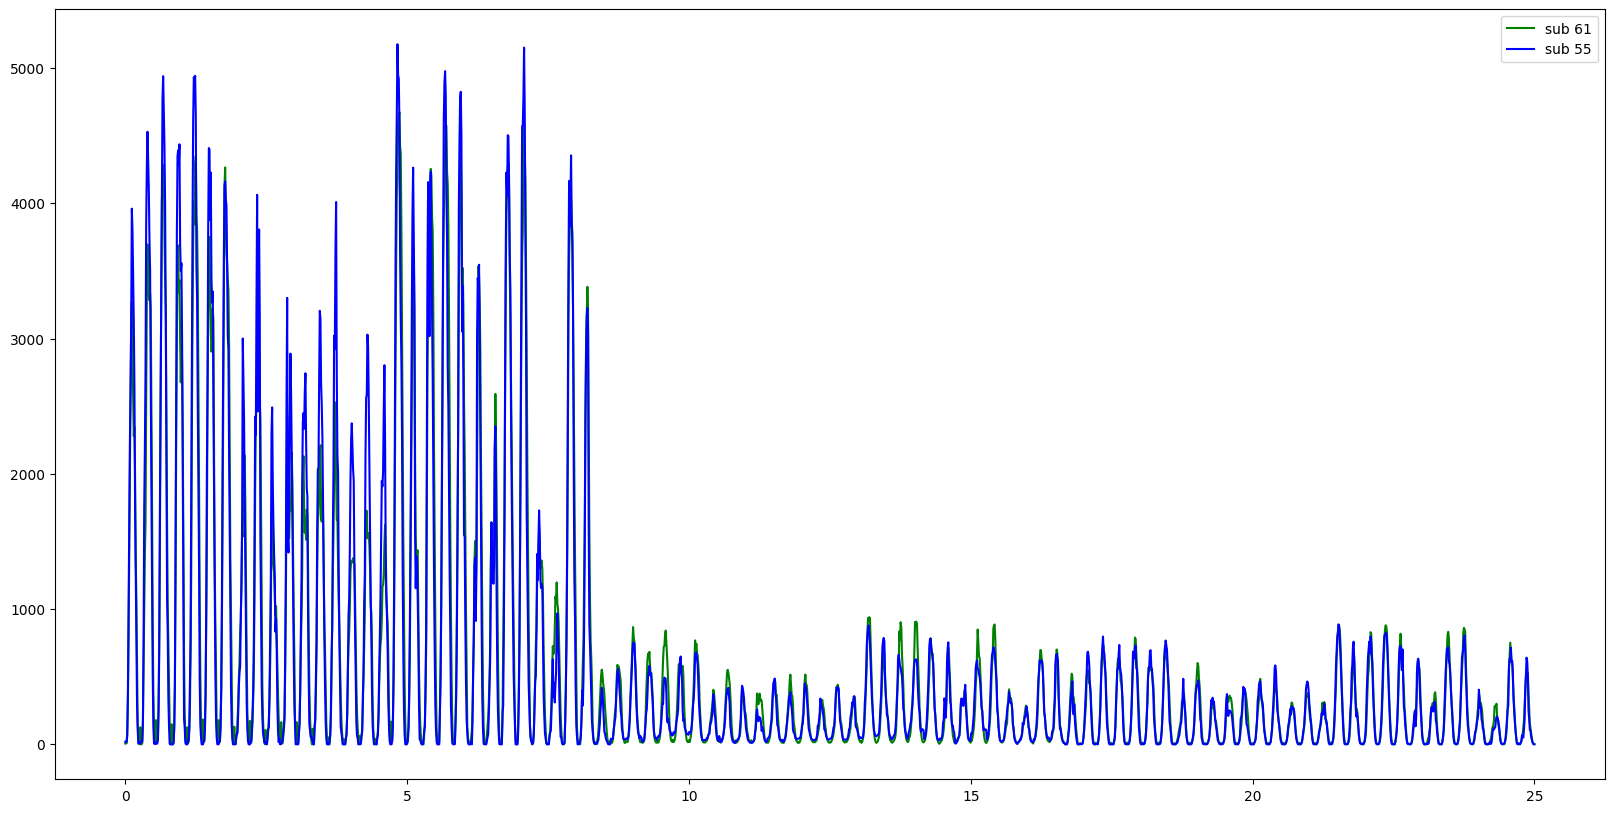

63.51992896125966


In [32]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
s60 = pd.read_csv("sub61.csv")
s55 = pd.read_csv("sub55.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub61.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 61") 

y2 = [] 
  
with open('sub55.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 55") 

plt.legend() 
plt.show()

print(mean_absolute_error(s55, s60))